In [6]:
import numpy as np
import pandas as pd
from simulation_util import  create_optimal_task, calculate_delta, add_delta_to_competency, calc_task_complexities, create_learner_population
from simulation_const import MAX_TASK_COUNT, DQL_MODEL

In [7]:
import random
from tqdm import trange

def simulate_task_adaptation(learner_count: int, mean_competency: float, bonus_distribution: tuple[4]):

    learner_population = create_learner_population(
        learner_count, MAX_TASK_COUNT, DQL_MODEL, mean_competency, bonus_distribution)

    simulationLog = [{
        "tasks": [],
        "competencies": [],
        "scaffolding_bonuses": [],
        "deltas": []
    } for _ in range(learner_count)]
    
    for j in trange(learner_count):
        task_count = random.randint(10, MAX_TASK_COUNT)
        
        for i in range(task_count): 
            learner_competency = learner_population["learner_competencies"][j]
            scaffolding_bonus = learner_population["scaffolding_competence_bonus_per_step_and_learner"][i][j]

            task = create_optimal_task(
                DQL_MODEL, learner_competency, scaffolding_bonus)

            task_complexities = calc_task_complexities(task)
            delta = calculate_delta(
                learner_competency, task_complexities, scaffolding_bonus)

            # update the learner competency in the global learner population
            learner_population["learner_competencies"][j] = add_delta_to_competency(
                learner_competency, delta)    

            simulationLog[j]["tasks"].append(task)
            simulationLog[j]["competencies"].append(learner_competency)
            simulationLog[j]["scaffolding_bonuses"].append(scaffolding_bonus)
            simulationLog[j]["deltas"].append(delta)
            
    return simulationLog

In [8]:
def saveData(simulationLog, fileName):
    records = []
    order_id = 1
    problem_id = 1

    # Iterate through each student 
    for studentId in range(len(simulationLog)):
        for taskIndex in range(len(simulationLog[studentId]["tasks"])):
            # Iterate through categories
            for category_i, (category_name, category_elements) in enumerate(DQL_MODEL.items()):
                # Iterate through elements in category
                for element_i, element in enumerate(category_elements):
                    # Get delta for this element
                    delta = simulationLog[studentId]["deltas"][taskIndex][category_name][element_i]
                    
                    # Create record with zero-padded IDs
                    # Calculate position: (category_i * elements_per_category) + element_i
                    skill_position = (category_i * len(category_elements)) + element_i + 1
                    record = {
                        'order_id': f'{order_id:08d}',
                        'user_id': f'{studentId+1:06d}',
                        'sequence_id': f'{studentId+1:06d}',
                        'skill_id': skill_position,
                        'problem_id': f'{problem_id:08d}',
                        'correct': 1 if delta > 0 else 0
                    }
                    records.append(record)
                    order_id += 1  
            problem_id += 1

    # Create and save dataframe
    df = pd.DataFrame(records)
    df.to_csv(fileName+'.csv', index=False, sep=',')

100%|██████████| 1000/1000 [00:01<00:00, 549.76it/s]


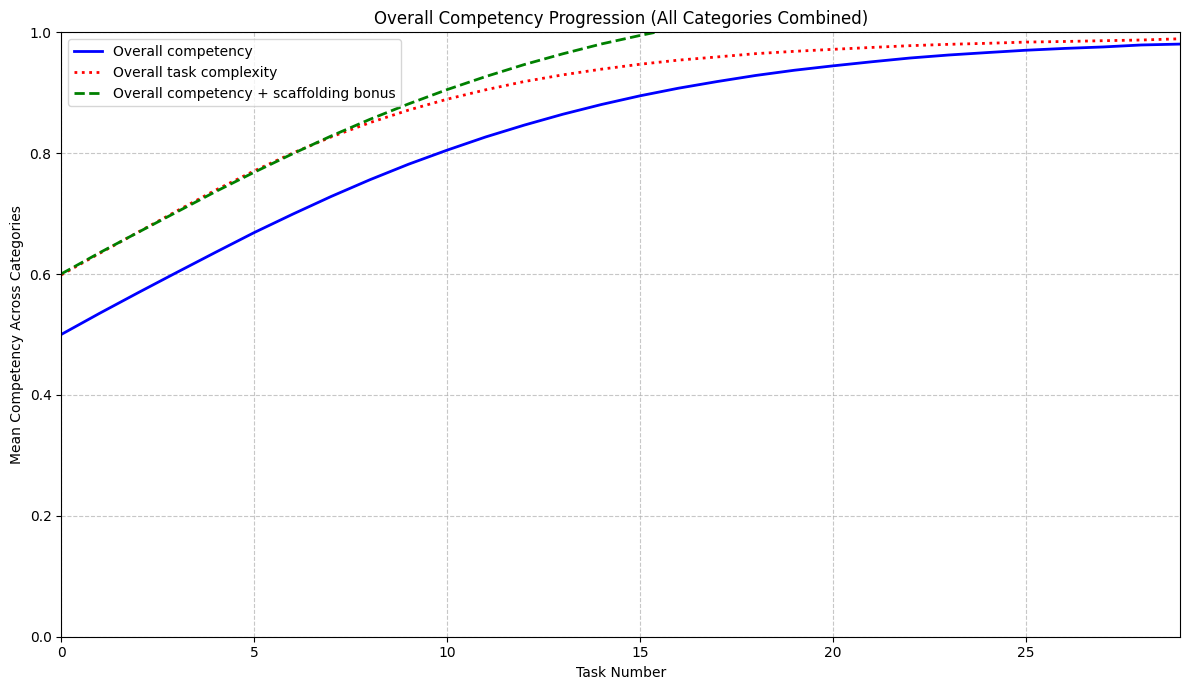

In [9]:

from simulation_plot import plot_mean_simulation_log, plot_mean_across_categories


def createSimData(learner_count, mean_competency, bonus_distribution):
    simulationLog = simulate_task_adaptation(learner_count, mean_competency, bonus_distribution)
    plot_mean_across_categories(simulationLog)
    return simulationLog

# (learner_count, mean_competency, bonus_distribution)
# bonus_distribution = (mean, var, min, max)
simVariations = [
    (1000, 0.5, (0.1, 0.002, 0, 0.2)),
]

# Initialize datasets array with the correct length
dataset = np.array([createSimData(*simVariation) for simVariation in simVariations]).flatten()
np.random.shuffle(dataset)

saveData(dataset, 'dataset')

In [10]:
print(dataset.shape)

(1000,)
